In [1]:
import boto3
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import urllib


import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


In [2]:
def scan_all(table):
    response = table.scan()
    data = response['Items']
    while 'LastEvaluatedKey' in response:
        response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        data.extend(response['Items'])
    return data

In [3]:
dynamodb = boto3.resource('dynamodb')
idealista_scrap_table = dynamodb.Table('scrapped_ads')
imovirtual_scrap_table = dynamodb.Table('imovirtual_scrap')
idealista_scrap_rows = scan_all(idealista_scrap_table) #idealista_scrap_table.scan()
imovirtual_scrap_rows = scan_all(imovirtual_scrap_table) #imovirtual_scrap_table.scan()

In [4]:
geocode_table = dynamodb.Table('geocode')
geocode_rows = scan_all(geocode_table)

In [5]:
df_idealista = pd.DataFrame(idealista_scrap_rows)
df_imovirtual = pd.DataFrame(imovirtual_scrap_rows)

print('Idealista: {}\nImovirtual: {}'.format(len(df_idealista), len(df_imovirtual)))

Idealista: 1128
Imovirtual: 518


In [6]:
#############################################################
#### DATA TRANSFORM
#############################################################

def calc_price_by_area(df):
    df['created_datetime'] = pd.to_datetime(df['created'], format='%d-%m-%Y %H:%M:%S')
    df['size'] = pd.to_numeric(df['size'])
    df['price'] = pd.to_numeric(df['price'])
    df['price_area'] = df.apply(lambda x: x['price'] / x['size'], axis=1)
    return df


def remove_outliers(df):
    return df[df.between(df.quantile(.15), df.quantile(.85))]

def count_per_day(df):
    res_def = df.groupby('created_datetime').count()['size'].to_frame()
    res_def.columns = ['count']
    return res_def

def mean_per_weekday(df):
    res_def = df.groupby('created_datetime').count()['size'].to_frame()
    res_def = res_def.assign(weekday=res_def.index.dayofweek)
    res_def = res_def.groupby('weekday').mean()
    res_def.columns = ['count']
    return res_def
    
df_idealista = calc_price_by_area(df_idealista)
df_imovirtual = calc_price_by_area(df_imovirtual)

In [7]:
#############################################################
#### PLOT
#############################################################

def plot_ad_count(df_arr):
    fig,axs = plt.subplots(1, 2, figsize = (15, 5))

    # add count per day
    ax = axs[0]
    for name, df in df_arr.items():
        count_df = count_per_day(df)
        ax.plot(count_df.index, count_df, label=name)

    ax.set_xlabel("day")
    ax.set_ylabel("count")
    ax.legend(loc='best')
    ax.set_title("Ad count per day")

    plt.gcf().autofmt_xdate()
    
    # ad mean per day
    ax = axs[1]
    df_count_arr = [mean_per_weekday(df) for df in df_arr.values()]
    merged_df = pd.DataFrame()
    for name, df in df_arr.items():
        df = mean_per_weekday(df)
        df.columns = [name]
        merged_df = merged_df.merge(df, left_index=True, right_index=True,how='outer', sort=True)
    x_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    merged_df.index = x_names
    merged_df.plot.bar(ax=ax);

    ax.set_xlabel("weekday")
    ax.set_ylabel("count")
    ax.legend(loc='best')
    ax.set_title("Ad count per weekday")

def plot_cumulative_ad_count(df_arr):
    fig,axs = plt.subplots(1, 2, figsize = (15, 5))
    
    all_ad_df = pd.DataFrame()
    

    # add count per day
    ax = axs[0]
    for name, df in df_arr.items():
        count_df = count_per_day(df).cumsum()
        ax.plot(count_df.index, count_df, label=name)
        
    all_ad_df = pd.concat(df_arr.values())
    cumsum_all_ad = all_ad_df.groupby('created_datetime').count()['size'].cumsum()
    ax.plot(cumsum_all_ad.index, cumsum_all_ad, label='all')
    
    ax.set_xlabel("day")
    ax.set_ylabel("count")
    ax.legend(loc='best')
    ax.set_title("Ad count sum per day")
    
    plt.gcf().autofmt_xdate()
    
    ax = axs[1]
    ax.pie([len(df) for df in df_arr.values()], labels=[name for name in df_arr.keys()])
    ax.legend(loc='best')
    ax.set_title("Ad count")

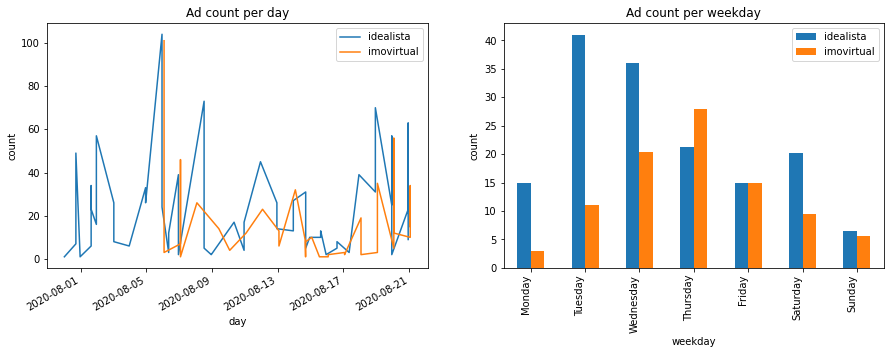

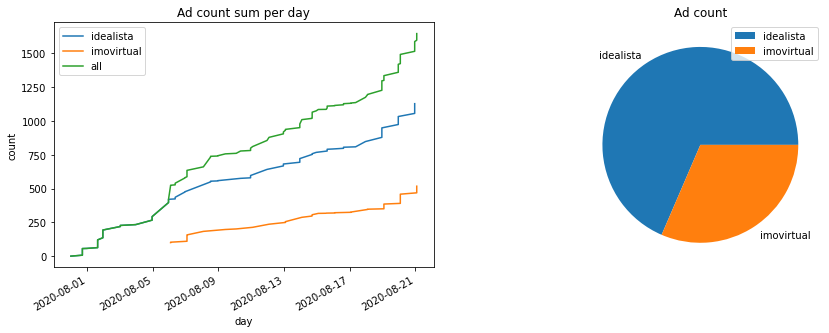

In [8]:
#############################################################
####
#############################################################

# idealista collected at 23h00
# imovirtual collected at 02h00
df_dict = { 'idealista': df_idealista, 'imovirtual': df_imovirtual }
plot_ad_count(df_dict)
plot_cumulative_ad_count(df_dict)

In [9]:
#############################################################
#### TRANSFORM GEOGRAPHICAL DATA
#############################################################

geocode_dic = {}
for r in geocode_rows:
    geocode_dic[r['query']] = r['geo']

def update_geo_dic(df):
    geocode_dic = {}
    counter = {}
    for geo in df[['geo','address']].itertuples():
        data = geo[1]
        if data == data and (len(data) and len(data[0])):
            geocode_dic[geo[2]] = data
    return geocode_dic

geocode_dic.update(update_geo_dic(df_idealista))

def count_geo_type(field_name, df):
    counter = {}
    total_found = 0
    for addr in df['address']:
        if addr not in geocode_dic:
            continue
        found = False
        for g in geocode_dic[addr]:
            if g[field_name] == None:
                continue
            if g[field_name] not in counter:
                counter[g[field_name]] = 0
            counter[g[field_name]] += 1
            found = True
            break
        if not found:
            if None not in counter:
                counter[None] = 0
            counter[None] += 1
        else:
            total_found += 1
    return counter, total_found, len(df)


# print how many geo details found per field
for k in list(df_idealista['geo'][0][0].keys()):
    idealista = count_geo_type(k, df_idealista)
    imovirtual = count_geo_type(k, df_imovirtual)
    print('{}'.format(k)) 
    print('\tFound: {:<5} Total: {:<5} Percent with Geo Field: {:>5.2f}% '.
          format(idealista[1], idealista[2], 100*idealista[1]/idealista[2]))
    print('\tFound: {:<5} Total: {:<5} Percent with Geo Field: {:>5.2f}% '.
          format(imovirtual[1], imovirtual[2], 100*imovirtual[1]/imovirtual[2]))


    
def add_geo_type(field_name, df):
    res = []
    total_found = 0
    for _, r in df.iterrows():
        addr = r['address']
        if addr not in geocode_dic:
            res.append(None)
            continue
        found = False
        for g in geocode_dic[addr]:
            if g[field_name] == None:
                continue
            res.append(g[field_name])
            found = True
            break
        if not found:
            res.append(None)
    return res

continent
	Found: 888   Total: 1128  Percent with Geo Field: 78.72% 
	Found: 111   Total: 518   Percent with Geo Field: 21.43% 
country
	Found: 888   Total: 1128  Percent with Geo Field: 78.72% 
	Found: 111   Total: 518   Percent with Geo Field: 21.43% 
latitude
	Found: 888   Total: 1128  Percent with Geo Field: 78.72% 
	Found: 111   Total: 518   Percent with Geo Field: 21.43% 
confidence
	Found: 888   Total: 1128  Percent with Geo Field: 78.72% 
	Found: 111   Total: 518   Percent with Geo Field: 21.43% 
county
	Found: 0     Total: 1128  Percent with Geo Field:  0.00% 
	Found: 0     Total: 518   Percent with Geo Field:  0.00% 
locality
	Found: 494   Total: 1128  Percent with Geo Field: 43.79% 
	Found: 85    Total: 518   Percent with Geo Field: 16.41% 
administrative_area
	Found: 56    Total: 1128  Percent with Geo Field:  4.96% 
	Found: 22    Total: 518   Percent with Geo Field:  4.25% 
label
	Found: 888   Total: 1128  Percent with Geo Field: 78.72% 
	Found: 111   Total: 518   Percent 

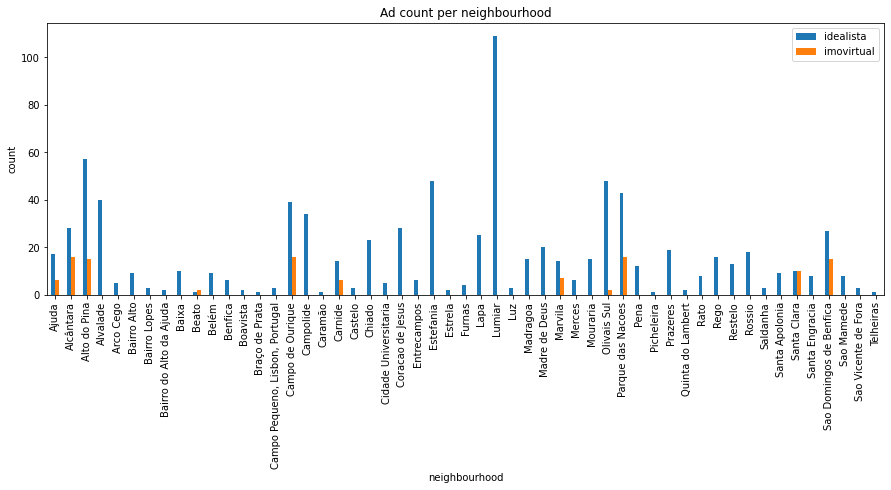

In [10]:
# add geo field to rows
field_name = 'neighbourhood'
df_idealista[field_name] = add_geo_type(field_name, df_idealista)
df_imovirtual[field_name] = add_geo_type(field_name, df_imovirtual)

# add geo field to rows
df_dict = { 'idealista': df_idealista, 'imovirtual': df_imovirtual }

def plot_count_per_area(df_dict):
    fig,axs = plt.subplots(1, 1, figsize = (15, 5))
    
    ax = axs
    merged_df = pd.DataFrame()
    for name, df in df_dict.items():
        df = pd.DataFrame(df.groupby(field_name).count()['size']) # using external variable field_name
        df.columns = [name]
        merged_df = merged_df.merge(df, left_index=True, right_index=True, how='outer', sort=True)
    merged_df.plot.bar(ax=ax);

    ax.set_xlabel("neighbourhood")
    ax.set_ylabel("count")
    ax.legend(loc='best')
    ax.set_title("Ad count per neighbourhood")
    
plot_count_per_area(df_dict)